In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(4)
np.random.seed(4)

In [2]:
BATCH_SIZE = 128
NUM_ITERS = int(2e4)
CRITERION = nn.CrossEntropyLoss()  


In [3]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

EPOCHS = int(NUM_ITERS / (len(trainset) / BATCH_SIZE))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

Files already downloaded and verified
Files already downloaded and verified
cuda


In [4]:

# Block

class ConvBlock(nn.Module):

    def __init__(self, stride=1, padding=1, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn1 = nn.BatchNorm2d(8)

        self.relu1 = nn.ReLU()        

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn2 = nn.BatchNorm2d(8)

        self.relu2 = nn.ReLU()       

         


    def forward(self, x):

        out = self.conv1(x)

        if self.batch_norm:
            out = self.bn1(out)

        out = self.relu1(out)

        out = self.conv2(x)

        if self.batch_norm:
            out = self.bn2(out)

        out = self.relu2(out)

        return out

# Model
class CNNModel(nn.Module):
    def __init__(self, batch_norm=False, N=10):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 28 x 28

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=2, padding=0)
        # Size: 12 x 12

        # Dynamic block num
        self.blocks = nn.Sequential(*[ConvBlock(batch_norm=batch_norm) for _ in range(N)])
        # Size: 12 x 12

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=0)                    
        # Size: 5 X 5

        self.fc1 = nn.Linear(5 * 5 * 4, 100, bias=True) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10, bias=False) 


    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        out = self.blocks(out)         # How is the shape the same after this???
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [5]:

def calc_accuracy(model, train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images
        images, labels = images.requires_grad_().to(DEVICE), labels.to(DEVICE)        

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(model): 
    print(f'Training for {EPOCHS} epochs')
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
    accuracy = {'train': [], 'test': []}

    for epoch in range(EPOCHS):    
        for i, (images, labels) in enumerate(train_loader): 
            # This will load batch_size amount of samples
            images, labels = images.requires_grad_().to(DEVICE), labels.to(DEVICE)                     

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = CRITERION(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(model, train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy(model) # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)

## a) Plot Train and Test accuracy

Training for 51 epochs
Epoch: 0 Loss: 2.3027138710021973. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 1 Loss: 2.3021628856658936. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 2 Loss: 2.302372455596924. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 3 Loss: 2.3020453453063965. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 4 Loss: 2.302574872970581. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 5 Loss: 2.302501916885376. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 6 Loss: 2.3025786876678467. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 7 Loss: 2.3028206825256348. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 8 Loss: 2.3024020195007324. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 9 Loss: 2.303006172180176. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 10 Loss: 2.303027629852295. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 11 Loss: 2.3028082847595215. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 12 Loss: 2.3026418685913086. Train Accuracy: 10.0

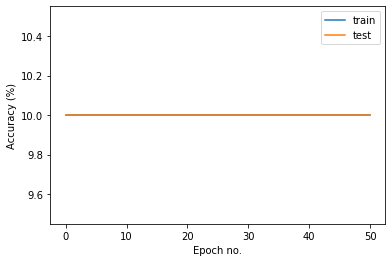

In [6]:

no_batch_norm = CNNModel().to(DEVICE)
nbn_history = train(no_batch_norm)
nbn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')

Training for 51 epochs
Epoch: 0 Loss: 1.9252649545669556. Train Accuracy: 27.035999298095703, Test Accuracy: 26.739999771118164
Epoch: 1 Loss: 1.6570892333984375. Train Accuracy: 34.625999450683594, Test Accuracy: 34.540000915527344
Epoch: 2 Loss: 1.4723645448684692. Train Accuracy: 38.26199722290039, Test Accuracy: 38.0
Epoch: 3 Loss: 1.5483534336090088. Train Accuracy: 41.33799743652344, Test Accuracy: 40.619998931884766
Epoch: 4 Loss: 1.5105412006378174. Train Accuracy: 42.31999969482422, Test Accuracy: 42.0
Epoch: 5 Loss: 1.3452765941619873. Train Accuracy: 46.45800018310547, Test Accuracy: 45.90999984741211
Epoch: 6 Loss: 1.5339981317520142. Train Accuracy: 47.5099983215332, Test Accuracy: 46.78999710083008
Epoch: 7 Loss: 1.3911526203155518. Train Accuracy: 49.305999755859375, Test Accuracy: 48.11000061035156
Epoch: 8 Loss: 1.36250901222229. Train Accuracy: 49.49799728393555, Test Accuracy: 48.28999710083008
Epoch: 9 Loss: 1.3342885971069336. Train Accuracy: 50.49399948120117, Tes

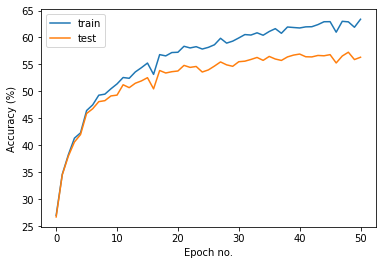

In [7]:
batch_norm = CNNModel(batch_norm=True).to(DEVICE)
bn_history = train(batch_norm)
bn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    

## b) Optimal value of N w/o batch normalization

Training for 51 epochs
Epoch: 0 Loss: 2.307652473449707. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 1 Loss: 2.300196409225464. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 2 Loss: 2.275211811065674. Train Accuracy: 16.219999313354492, Test Accuracy: 16.10999870300293
Epoch: 3 Loss: 2.046011447906494. Train Accuracy: 22.917999267578125, Test Accuracy: 23.75
Epoch: 4 Loss: 1.9568980932235718. Train Accuracy: 27.52199935913086, Test Accuracy: 28.469999313354492
Epoch: 5 Loss: 2.0499563217163086. Train Accuracy: 29.12799835205078, Test Accuracy: 29.579999923706055
Epoch: 6 Loss: 1.9133882522583008. Train Accuracy: 31.24599838256836, Test Accuracy: 32.16999816894531
Epoch: 7 Loss: 1.9294506311416626. Train Accuracy: 30.74799919128418, Test Accuracy: 31.51999855041504
Epoch: 8 Loss: 1.7494490146636963. Train Accuracy: 33.74599838256836, Test Accuracy: 33.97999954223633
Epoch: 9 Loss: 1.7453018426895142. Train Accuracy: 34.961997985839844, Test Accuracy: 35.05999755859375
Epoch: 10 

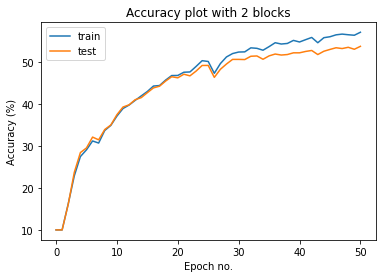

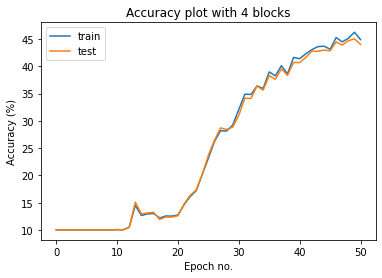

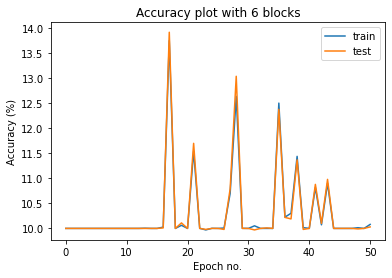

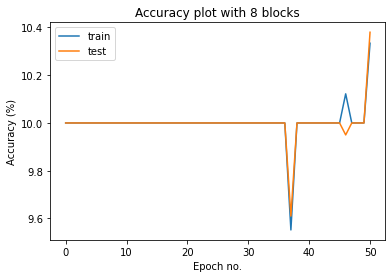

In [8]:
nbn_models = []
nbn_histories = []
for test_n in range(2, 10):
    if test_n % 2 == 0: # if it's even
        model = CNNModel(N=test_n).to(DEVICE)
        nbn_models.append(model)
        history = train(model)
        nbn_histories.append(history)
        history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
        plt.title(f'Accuracy plot with {test_n} blocks')
    


### Analysis

From these experiments, we can see that _ is the optimal number of blocks when using a CNN without batch normalization. This was a little surprising to me, as I thought that increasing the depth of the model would directly correlate to better performance. However, we see that this isn't really the case.

## c) Plot 2 misclassified and 2 correctly classified samples for each class